In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

from helper import *


# ARIMA: Autoregressive Integrated Moving Average

## By Team Fourier
CS189 Project T Final

This notebook will provide an introduction into ARIMA, short for autoregressive integrated moving average. ARIMA models aim to model time series data such as the weather, stock prices, or product sales over a period of time. 

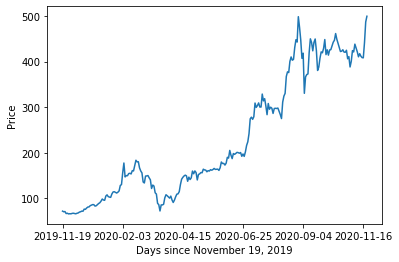

In [134]:
data = pd.read_csv('TSLA.csv')
time = np.array(data['Date'])
price = np.array(data['Close'])

plt.plot(time, price)
plt.xticks(time[::50])
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.show()

For example, the graph above depicts the stock price of TSLA over time. The x-axis being time and the y-axis being f(t), the price at that point in time.

Clearly a basic linear model wouldn't be able to model such a function of time due to its non-linearity. However, we have previously learned ways to fit non-linear functions with linear regression using feature lifting. Maybe lifting some polynomial features might help?

## Trying Linear Regression

Linear features, linear regression

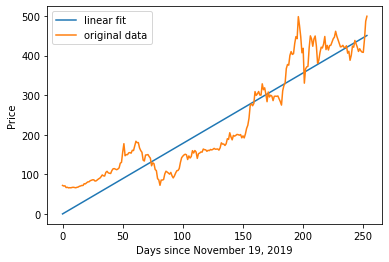

In [133]:
time_steps = np.arange(0, time.shape[0], 1).astype(np.int).reshape((time.shape[0], 1))
w = np.linalg.lstsq(time_steps, price)[0]

plt.plot(time_steps, w * time_steps, label='linear fit')
plt.plot(time_steps, price, label = 'original data')
plt.legend()
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.show()


Polynomial features, linear regression

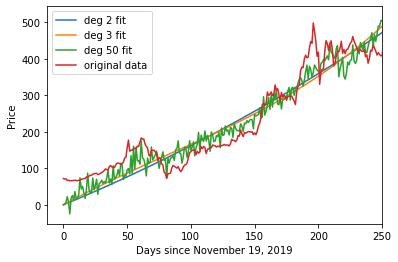

Error with degree 2 features: [546377.27562546]
Error with degree 3 features: [531613.00124715]
Error with degree 50 features: [401768.50799666]


In [132]:
def feature_lift(X, d=2):
    """
    This function computes second order variables
    for polynomial regression.
    Input:
    X: Independent variables.
    Output:
    A data matrix composed of both first and second order terms.
    """
    
    X = np.array(X)
    X_data = []
    
    for deg in range(1, d+1):
        X_data.append(np.power(X, deg))
        
    return np.hstack(X_data)

second_order_time_steps = feature_lift(time_steps, d=2)
w_2, err_2, _, _ = np.linalg.lstsq(second_order_time_steps, price)

third_order_time_steps = feature_lift(time_steps, d=3)
w_3, err_3, _, _ = np.linalg.lstsq(third_order_time_steps, price)

fifty_order_time_steps = feature_lift(time_steps, d=50)
w_50, err_50, _, _ = np.linalg.lstsq(fifty_order_time_steps, price)


plt.plot(time_steps, second_order_time_steps @ w_2.T, label='deg 2 fit')
plt.plot(time_steps, third_order_time_steps @ w_3.T, label='deg 3 fit')
plt.plot(time_steps, fifty_order_time_steps @ w_50.T, label='deg 50 fit')
plt.plot(time_steps, price, label = 'original data')

plt.xlim(right=250)
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.legend()
plt.show()

print('Error with degree 2 features: %s' % str(err_2))
print('Error with degree 3 features: %s' % str(err_3))
print('Error with degree 50 features: %s' % str(err_50))

Basically, any attempt to fit some sort of function using linear regression and feature lifting will be met with failure. Why? This is due to the nature of time series data. The problem that linear regressions try to solve is fitting some function to the data in its entirety. However, time series data, such as stock prices don't operate under the same assumptions. Does the stock price 1 year ago directly affect the stock price tomorrow? The answer is, not really. This understanding that only the previous n' << n observations are truly important to our model spawns this set of models that utilize the moving average, the first MA model, then the ARMA, and ARIMA models.

# Formulation of the ARIMA Model

The mathematical model behind ARIMA is:

\begin{align*}
ARIMA(p, d, q) = (1 - \phi_{1}L - \phi_{2}L^{2} - \phi_{3}L^{3}... - \phi_{p}L^{p}) (1 - L)^{d} y_{t} = c + (1 + \theta_{1} L + \theta_{2} L^{2}... + \theta_{q} L^{q}) \epsilon_{t}
\end{align*}

The L is the lag operator, $L^d y_{t} = y_{t - d}$.

The first group of terms, containing $\phi$'s, are the auto-regressive terms. Auto-regressive refers to the contribution of previous observations on the current observation. The parameter $p$ is the number of previous observations looked at. The $\phi$'s are their individual weighting. Intuitively, an observation 1 time step ago usually holds more weight than an observation 10 time steps ago.

The second term, $(1 - L)^{d}$, is the integrated term. This is the term that implements the idea of differencing, which is sometimes necessary to find a deeper relationship in the data. The time series function may not be able to model the observation themselves, but may be able to model the difference between successive observations.

The third and final term, containing $\theta$'s, represent the moving average portion of the model. This is the contribution of the previous $q$ terms, specifically their residuals to the residual at time t. The residuals, $\epsilon_{t}$, are standard normal distribution deviations of each observation from the predicted observation predicted by the model. These residuals are what we try to minimize when fitting parameters to the training data.

The constant c quantifies the drift of the model.

# Breaking Down the ARIMA Model

## Auto-Regressive (AR)

One of the fundamental building blocks of the ARIMA model is the AR portion of the model. The equation for a simple AR model is:

\begin{align*}
AR(p) = y_{t} = c + (\phi_{1}L + \phi_{2}L^{2} + \phi_{3}L^{3}... + \phi_{p}L^{p})y_{t} + \epsilon_{t}
\end{align*}

This equation can already begin to model functions under the assumption that current observations are simply derived from a linear combination of the p previous observations.

For the rest of this notebook, we'll be working with weather data instead of stock data.

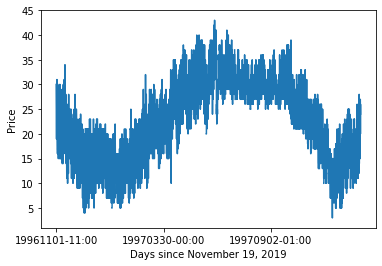

In [145]:
weather_data = pd.read_csv('weather_data.csv')
weather_time = weather_data['datetime_utc'][:8500]
weather_temp = weather_data[' _tempm'][:8500]

plt.plot(weather_time, weather_temp)
plt.xticks(weather_time[::3000])
plt.xlabel('time')
plt.ylabel('temp in deg C')
plt.xlabel('Days since November 19, 2019')
plt.ylabel('Price')
plt.show()
